In [220]:
!pip3 install torch
!pip3 install VaderSentiment
!pip3 install transformers
!pip3 install sentence-transformers
!pip3 install umap-learn
!pip3 install hdbscan
!pip3 install gensim
!pip3 install pyLDAvis

In [221]:
#import necessary libraries

import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

import torch
import transformers as ppb # pytorch transformers

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.sklearn

In [222]:
gc.set_threshold(20,5,5)
gc.collect()

1028

In [223]:
product_reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/pre_processed_data.csv')
product_reviews_ratings.head(2)

,asin,overall,verified,reviewText,reviewTime
0,0007444117,1,False,I was a huge fan when the Divergent series sta...,2016-09-03
1,0007177437,4,True,Excellent read.,2015-09-16


In [224]:
product_reviews_ratings['asin'].value_counts()

038568231X    8736
0312577222    7092
1683247353    4745
0553418025    4726
1503943372    4522
              ... 
0807085715       1
1598242717       1
0977760227       1
0874211638       1
0996292004       1
Name: asin, Length: 975727, dtype: int64

In [225]:
#Let's create a list of 5 most reviewed books from this list
product_list=product_reviews_ratings['asin'].value_counts().index[:5]
product_list

Index(['038568231X', '0312577222', '1683247353', '0553418025', '1503943372'], dtype='object')

In [226]:
#Let's start testing with the most reviewed item: '038568231X'
reviews_1=product_reviews_ratings[product_reviews_ratings['asin']=='038568231X']
reviews_1.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [227]:
selected_reviews=reviews_1[(reviews_1['overall']==3)|(reviews_1['overall']==4)]

In [228]:
#Creating a dataframe with only the text of selected reviews
data=selected_reviews[['reviewText']]

#reset index
data.reset_index(inplace=True)

#And let's drop all nulls
data.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [229]:
data.drop('index',axis=1,inplace=True)
data

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,reviewText
0,Pros: good pacing; not boring; easy to read in...
1,"Slow going at first, almost to the point of bo..."
2,"Everyone called this book the new ""Gone Girl""...."
3,This book was GREAT! I would've given it 5 sta...
4,"An easy read with a watchable, fraught heroine..."
...,...
3513,With how much buzz this book got I expected mo...
3514,Great reading looking forward to the movie.
3515,I always enjoy a story where the heroine is se...
3516,A talk show host mentioned this title on a loc...


In [230]:
#sentence embeddings
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
embeddings = model.encode(data['reviewText'], show_progress_bar=True)

In [231]:
#reduce dimensionality to 6, keeping neighbors at 100 
umap_embeddings = umap.UMAP(n_neighbors=100,n_components=6,metric='cosine').fit_transform(embeddings)

In [232]:
#clustering using HDBSCAN
clusters=hdbscan.HDBSCAN(min_cluster_size=16,min_samples=10,cluster_selection_epsilon=0.375,metric='euclidean',cluster_selection_method='eom').fit(umap_embeddings)

In [233]:
#Let's explore what clusters and the docs in each cluster

In [234]:
labels=np.unique(clusters.labels_)
labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [235]:
#we can use the UMAP method we used previously to create embedding in 2d and visualize the findings.
umap_embeddings_2D=umap.UMAP(n_neighbors=100,n_components=2,metric='cosine').fit_transform(embeddings)
df_umap_embeddings_2D=pd.DataFrame(umap_embeddings_2D,columns=['x','y'])
df_umap_embeddings_2D['label']=clusters.labels_


In [236]:
df_umap_embeddings_2D['label'].value_counts(normalize=True)  #the labels are from the 6 dimensional analysis. so value_counts of labels on 2D dataframe is equivalent to value_counts on 6D dataframe.

-1    0.422683
 8    0.329164
 9    0.093519
 6    0.037521
 0    0.036384
 3    0.033258
 5    0.014781
 4    0.011086
 7    0.007959
 1    0.007959
 2    0.005685
Name: label, dtype: float64

It appears we can capture over 95% of the reviews by considering the top 6 labels (including unclustered).

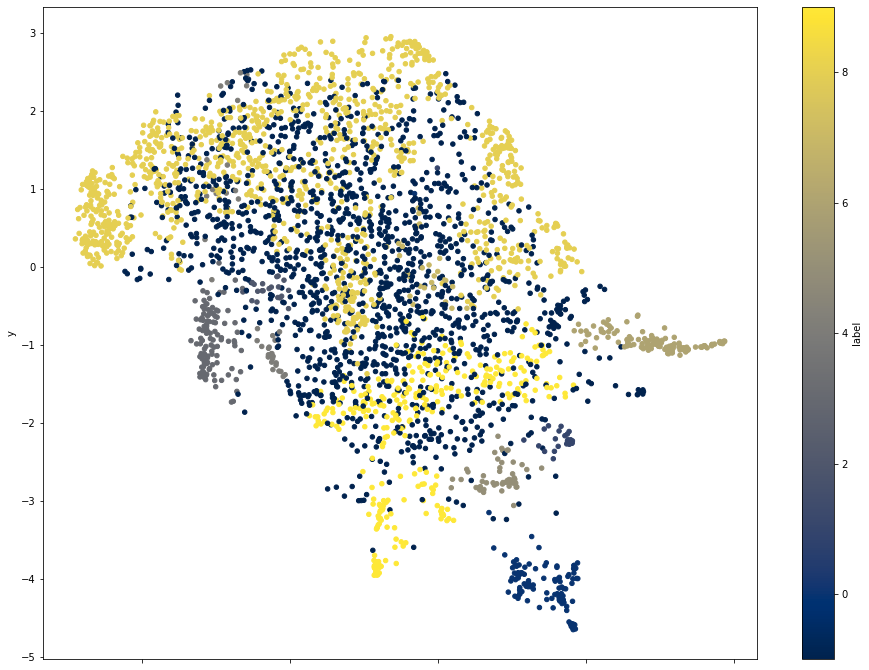

In [241]:
#Now let's plot df_umap_embeddings_2D

df_umap_embeddings_2D.plot(x='x',y='y',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

plt.savefig('/content/drive/My Drive/amazon_reviews_project/images/clustered_embedding_all_23.png')

In [242]:
#Let's create a column with labels in the original dataframe
data['label']=df_umap_embeddings_2D['label']
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,label
0,Pros: good pacing; not boring; easy to read in...,8
1,"Slow going at first, almost to the point of bo...",-1
2,"Everyone called this book the new ""Gone Girl""....",-1
3,This book was GREAT! I would've given it 5 sta...,3
4,"An easy read with a watchable, fraught heroine...",-1
...,...,...
3513,With how much buzz this book got I expected mo...,8
3514,Great reading looking forward to the movie.,3
3515,I always enjoy a story where the heroine is se...,-1
3516,A talk show host mentioned this title on a loc...,-1


clusters larger than 2% of total number of reviews accounts for more than 95% of the sample. So let's create a map with only those clusters.

In [243]:
selected_clusters=[i for i in range(-1,10) if df_umap_embeddings_2D['label'].value_counts(normalize=True)[i]>0.02]
selected_clusters

[-1, 0, 3, 6, 8, 9]

Let's create a map with just these

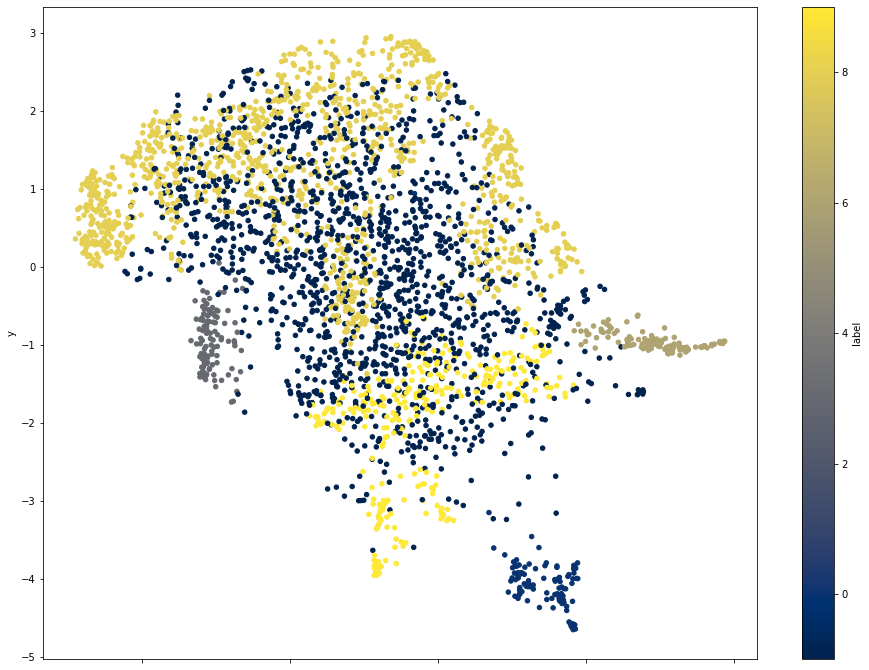

In [244]:
df_umap_embeddings_2D_selected_clusters=df_umap_embeddings_2D[df_umap_embeddings_2D['label'].isin(selected_clusters)]
df_umap_embeddings_2D_selected_clusters.plot(x='x',y='y',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

plt.savefig('/content/drive/My Drive/amazon_reviews_project/images/clustered_embedding_selected_23.png')

It's important to remember that the figure above take data with large number of dimensions and shows its projection on a 2D surface. The visual might be a little more illustrative if we plot it in 3D, instead. So let's try that.

In [245]:
umap_embeddings_3D=umap.UMAP(n_neighbors=100,n_components=3,metric='cosine').fit_transform(embeddings)
df_umap_embeddings_3D=pd.DataFrame(umap_embeddings_3D,columns=['x','y','z'])
df_umap_embeddings_3D['label']=clusters.labels_

In [246]:
df_umap_embeddings_3D_selected_clusters

,x,y,z,label
0,4.609529,-9.819734,-0.464972,9
1,6.936601,-9.639066,1.470318,9
2,5.704594,-9.441887,0.410677,-1
3,5.362218,-10.401222,0.842918,2
4,5.481509,-9.134027,-0.100228,-1
...,...,...,...,...
3513,6.222676,-9.386548,-0.347823,9
3514,5.078216,-11.058634,1.695393,2
3515,4.997629,-9.197268,0.037259,-1
3516,5.367936,-10.138680,1.538207,-1


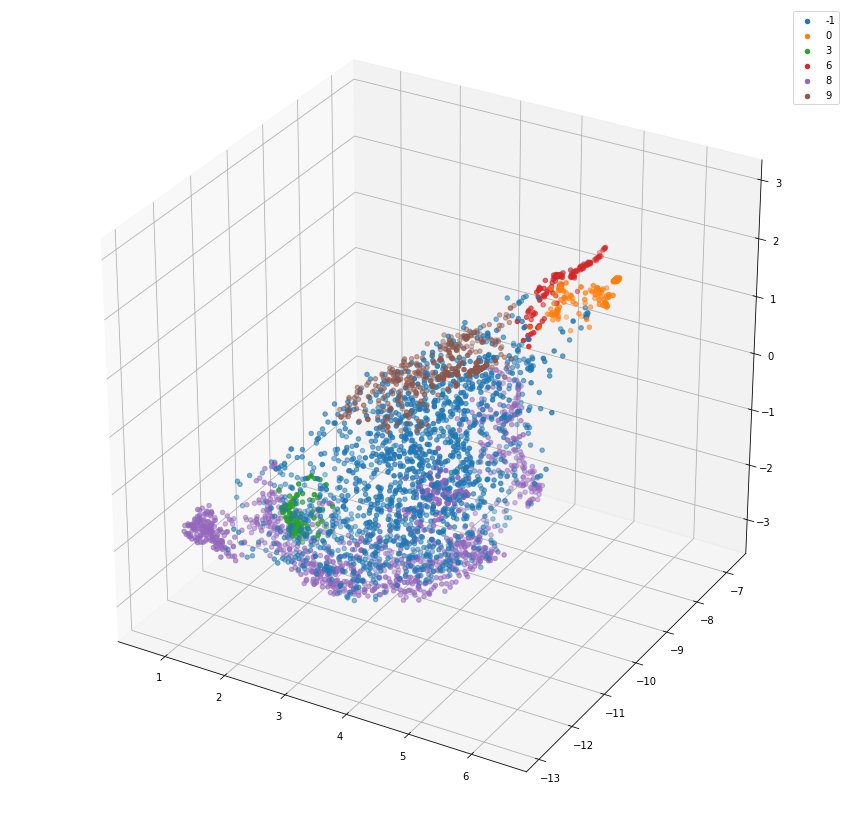

In [270]:
df_umap_embeddings_3D_selected_clusters=df_umap_embeddings_3D[df_umap_embeddings_3D['label'].isin(selected_clusters)]
#df_umap_embeddings_3D_selected_clusters.plot(x='x',y='y',z='z',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

#plot_3d = plt.figure().gca(projection='3d',alpha=0.5,fc='cividis')
#plot_3d.scatter(df_umap_embeddings_3D_selected_clusters['x'], df_umap_embeddings_3D_selected_clusters['y'], df_umap_embeddings_3D_selected_clusters['z'],c = cdict[g], label = g)

#group = selected_clusters
#cdict = 'cividis'

#x=df_umap_embeddings_3D_selected_clusters['x']
#y=df_umap_embeddings_3D_selected_clusters['y']
#z=df_umap_embeddings_3D_selected_clusters['z']

#fig, ax = plt.subplots()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for cluster in selected_clusters:
    ax.scatter(df_umap_embeddings_3D_selected_clusters.loc[df_umap_embeddings_3D_selected_clusters['label']==cluster]['x'],\
               df_umap_embeddings_3D_selected_clusters.loc[df_umap_embeddings_3D_selected_clusters['label']==cluster]['y'],\
               df_umap_embeddings_3D_selected_clusters.loc[df_umap_embeddings_3D_selected_clusters['label']==cluster]['z'],\
               cmap='cividis',label=cluster)
ax.legend()
plt.savefig('/content/drive/My Drive/amazon_reviews_project/images/clustered_3D_embedding_selected_23.png')

In [248]:
#We can label the original dataframe and extract reviews corresponding to each label.

data_selected_clusters=data[data['label'].isin(selected_clusters)].copy(deep=True)
data_selected_clusters

,reviewText,label
0,Pros: good pacing; not boring; easy to read in...,8
1,"Slow going at first, almost to the point of bo...",-1
2,"Everyone called this book the new ""Gone Girl""....",-1
3,This book was GREAT! I would've given it 5 sta...,3
4,"An easy read with a watchable, fraught heroine...",-1
...,...,...
3513,With how much buzz this book got I expected mo...,8
3514,Great reading looking forward to the movie.,3
3515,I always enjoy a story where the heroine is se...,-1
3516,A talk show host mentioned this title on a loc...,-1


We'll identify the prominent themes in each of these clusters using TF-IDF. Since we'll be performing this operation several times, this is a good place to write an function that would do it for us.

In [249]:
def create_doc(input_dataframe,clusters_to_select):
  docs=[]
  for label in clusters_to_select:
    doc=input_dataframe[input_dataframe['label']==label]
    docs.append(doc)
  return docs

In [250]:
docs=create_doc(data_selected_clusters,selected_clusters)
print(docs)

[                                             reviewText  label
1     Slow going at first, almost to the point of bo...     -1
2     Everyone called this book the new "Gone Girl"....     -1
4     An easy read with a watchable, fraught heroine...     -1
8     Good reading, story moves along well.  Good st...     -1
9     This book makes you feel uncomfortable as you'...     -1
...                                                 ...    ...
3510  The characters held my attention throughout. F...     -1
3511  I generally don't review books, but after read...     -1
3515  I always enjoy a story where the heroine is se...     -1
3516  A talk show host mentioned this title on a loc...     -1
3517  I really enjoyed the book. It had some interes...     -1

[1487 rows x 2 columns],                                    reviewText  label
5                      Good read, glad I did.      0
42                          Pretty good read.      0
46    Good read even though I figured it out.      0
51   

In [251]:
def docs_TFIDF_vectorizer(docs):
  from sklearn.feature_extraction.text import TfidfVectorizer

  stop_words = text.ENGLISH_STOP_WORDS.union(['00', '10', '100', '12', '15', '16', '20', '200', '24', '25',\
       '2nd', '30', '40', '45', '50', '60', '75', '80', '90','!',"''","'m","'s",',','.','...','He','I','It','My','Of','``',\
        '!',"''","'m","'re","'s",',','-','.','...','9','An','Ca','Do','I','It','S.','``','!',"''","'s",'(',')',',','-','.',\
        'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y','&',"'ll",'-D','5',':','?',\
        "'", '0', '1', '2', '3', '4', '6', '7', '8', 'A', 'C', 'D', 'H', 'M', 'O', 'S', '`','#',"'ve",'*','--','..','....','10/10','4/5',';',\
        'As','At','HE','IS','IT','If','In','MY','No','ON','On','PR','SO','So','St','To','US','We','/', 'E', 'N', 'P', 'R', 'T', 'U', 'W', 'Y',\
        '$','%',"'S","'d",'.....','1/2','1/3','105','12-lead','125','14','150','198','1\\23\\18','22','221','27','3-3.5','35','AM','Be','By',\
        'CK','DJ','De','Dr','HM','JE','K.','L','MB','Mr','Ms','R.','TO','W.','YA','B', 'J', 'K', '\\','@','Im','Me','Is','000','100ish','11',\
        '178','191','1945','1st','2015','2016','260','36','360','3rds','3star','55','70','78','80s','86','87','99','_____'])
  
  #initialize TFIDF vectorizer
  vectorizer = TfidfVectorizer(stop_words=stop_words)

  #create an empty list
  tfidf_vectorized_docs=[]

  #loop over the docs
  for doc in docs:
    X=vectorizer.fit_transform(doc['reviewText'])
    tfidf_vectorized_docs.append((vectorizer.get_feature_names(),X))
  
  return tfidf_vectorized_docs

In [252]:
tfidf_data=docs_TFIDF_vectorizer(docs)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['18', '23', 'ca', 'ck', 'dj', 'dr', 'hm', 'im', 'je', 'lead', 'll', 'mb', 'mr', 'ms', 'pr', 'st', 've', 'ya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [253]:
tfidf_data

[(['abit',
   'able',
   'aboard',
   'abrasive',
   'abrupt',
   'abruptly',
   'absolutely',
   'absorbed',
   'absorbing',
   'absurd',
   'abuse',
   'abusive',
   'accepted',
   'accidently',
   'acclaimed',
   'accounts',
   'accurate',
   'achieved',
   'achingly',
   'achololic',
   'acquaint',
   'acquainted',
   'act',
   'acting',
   'action',
   'actions',
   'active',
   'actively',
   'activity',
   'actual',
   'actually',
   'ad',
   'adaptation',
   'adapted',
   'add',
   'added',
   'addict',
   'addicted',
   'addicting',
   'addiction',
   'addictive',
   'adequate',
   'adjustment',
   'admirable',
   'admit',
   'admittedly',
   'adults',
   'advance',
   'affair',
   'affection',
   'affliction',
   'affords',
   'afternoon',
   'agape',
   'agatha',
   'age',
   'aged',
   'ages',
   'ago',
   'agree',
   'aha',
   'ahead',
   'air',
   'airplane',
   'airport',
   'al',
   'alas',
   'alchoholism',
   'alcohol',
   'alcoholic',
   'alcoholics',
   'alcoholism'

In [254]:
tfidf_data_complete_list=[pd.DataFrame(tfidf_data[i][1].todense(),columns=tfidf_data[i][0]) for i in range(len(tfidf_data))]

In [255]:
selected_clusters

[-1, 0, 3, 6, 8, 9]

The corresponding dataframes with tfidf data maybe called df_unclustered, df_0, df_3, df_6, df_8, df_9. We can easily assign names, as follows:

In [256]:
[df_unclustered,df_0,df_3, df_6, df_8, df_9]=[pd.DataFrame(tfidf_data[i][1].todense(),columns=tfidf_data[i][0]) for i in range(len(tfidf_data))]

Let's take a look at couple example to check if this worked.

In [257]:
df_unclustered.head(3)

,abit,able,aboard,abrasive,abrupt,abruptly,absolutely,absorbed,absorbing,absurd,abuse,abusive,accepted,accidently,acclaimed,accounts,accurate,achieved,achingly,achololic,acquaint,acquainted,act,acting,action,actions,active,actively,activity,actual,actually,ad,adaptation,adapted,add,added,addict,addicted,addicting,addiction,...,word,words,wordy,wore,work,worked,working,workings,works,world,worlds,worried,worse,worst,worth,worthy,wouldn,wound,woven,wow,wowed,wrapped,write,writer,writers,writes,writing,written,wrong,wrote,wwii,xmas,yarn,year,years,yes,young,zero,zimbabwe,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
df_0.head(2)

,absorbing,binding,book,captivating,character,club,consistent,dead,definitely,development,did,discussion,disturbing,dull,dunnit,engrossed,engrossing,enjoyable,enjoyed,entertaining,everybody,excellent,exciting,exercising,expected,extremely,far,feeling,figured,fine,fun,girl,glad,gone,good,goodread,great,interesting,inticing,kind,liked,little,love,moment,nutz,okay,overall,perspectives,pretty,priced,provoking,quite,read,reading,really,reasonably,recommend,right,riveting,setting,similar,sn,spell,story,style,super,suspensive,thought,thrilling,time,way,wonderful,worth,writing,written
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.682097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.682097,0.0,0.214624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.153054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.314880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.922187,0.0,0.0,0.0,0.224549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
df_6.head(2)

,actually,alright,amazing,attention,awesome,bad,boring,captivating,clear,compelling,couldn,curiosity,definitely,did,different,differnt,engaging,enjoy,enjoyable,enjoyed,entertaining,exceeded,excellent,exciting,expectations,fair,format,fun,good,got,great,gripping,held,holds,interesting,intriguing,involving,just,keeps,kept,like,liked,listening,love,loved,manage,meh,moves,nice,nicely,ok,okay,opinion,outstanding,pace,parts,pleased,predictable,pretty,realistic,really,recommend,regional,riveting,ry,says,story,thank,thoroughly,time,title,toes,ve,wasn,way,worth,wow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.80813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are finally ready to look at the most prominent words for each cluster.

In [260]:
df_unclustered.sum().nlargest(10)

book          89.596102
read          80.013034
good          73.527702
story         54.827493
great         42.119487
characters    41.972071
end           41.800054
ending        37.418550
kept          36.129858
enjoyed       35.897989
dtype: float64

In [266]:
#List comprehension to create separate list for each cluster
n_prominent_words=[df.sum().nlargest(10).index for df in [df_unclustered,df_0,df_3, df_6, df_8, df_9]]

In [267]:
df_n_prominent_words=pd.DataFrame(n_prominent_words).T
df_n_prominent_words.columns=['df_unclustered','df_0', 'df_3', 'df_6', 'df_8', 'df_9']

In [268]:
df_n_prominent_words

,df_unclustered,df_0,df_3,df_6,df_8,df_9
0,book,read,book,good,book,book
1,read,good,movie,ok,read,good
2,good,great,read,interesting,good,read
3,story,interesting,good,loved,story,great
4,great,enjoyable,great,enjoyed,slow,enjoyed
5,characters,written,wait,okay,characters,twists
6,end,reading,reading,entertaining,end,story
7,ending,fun,forward,enjoyable,little,mystery
8,kept,enjoyed,enjoyed,pretty,hard,summer
9,enjoyed,entertaining,looking,intriguing,girl,kept


### These are quick impressions on the clusters based on just the words with high TF-IDF values. 

**df_unclustered:**  This is our largest group. They enjoyed the characters, the story and especially the ending. The book was interesting to them.   
**df_1:**    
**df_6:**   
**df_7:**      
**df_13:**    

In [271]:
def salient_terms(i):
  pyLDAvis.enable_notebook()

  from sklearn.feature_extraction.text import TfidfVectorizer

  stop_words = text.ENGLISH_STOP_WORDS.union(['00', '10', '100', '12', '15', '16', '20', '200', '24', '25',\
      '2nd', '30', '40', '45', '50', '60', '75', '80', '90','!',"''","'m","'s",',','.','...','He','I','It','My','Of','``',\
      '!',"''","'m","'re","'s",',','-','.','...','9','An','Ca','Do','I','It','S.','``','!',"''","'s",'(',')',',','-','.',\
      'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y','&',"'ll",'-D','5',':','?',\
      "'", '0', '1', '2', '3', '4', '6', '7', '8', 'A', 'C', 'D', 'H', 'M', 'O', 'S', '`','#',"'ve",'*','--','..','....','10/10','4/5',';',\
      'As','At','HE','IS','IT','If','In','MY','No','ON','On','PR','SO','So','St','To','US','We','/', 'E', 'N', 'P', 'R', 'T', 'U', 'W', 'Y',\
      '$','%',"'S","'d",'.....','1/2','1/3','105','12-lead','125','14','150','198','1\\23\\18','22','221','27','3-3.5','35','AM','Be','By',\
      'CK','DJ','De','Dr','HM','JE','K.','L','MB','Mr','Ms','R.','TO','W.','YA','B', 'J', 'K', '\\','@','Im','Me','Is','000','100ish','11',\
      '178','191','1945','1st','2015','2016','260','36','360','3rds','3star','55','70','78','80s','86','87','99','_____'])
  vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=100)
  X=vectorizer.fit_transform(df_n_prominent_words.iloc[:,i])
  lda=LatentDirichletAllocation(n_components=3,random_state=22)
  lda.fit(X)
  p=pyLDAvis.sklearn.prepare(lda,X,vectorizer,R=3)
  pyLDAvis.save_html(p,'/content/drive/My Drive/amazon_reviews_project/images/LDA_File_unclustered_group_23.html')
  return p

salient_terms(0)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['18', '23', 'ca', 'ck', 'dj', 'dr', 'hm', 'im', 'je', 'lead', 'll', 'mb', 'mr', 'ms', 'pr', 'st', 've', 'ya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
1      0.094089  6.445164e-09       1        1  36.609396
0     -0.047045 -7.490862e-02       2        1  31.695302
2     -0.047045  7.490861e-02       3        1  31.695302, topic_info=         Term      Freq     Total Category  logprob  loglift
1  characters  1.000000  1.000000  Default   3.0000   3.0000
9       story  1.000000  1.000000  Default   2.0000   2.0000
2         end  1.000000  1.000000  Default   1.0000   1.0000
8        read  0.663561  0.999999   Topic1  -1.7079   0.5947
4     enjoyed  0.663561  0.999999   Topic1  -1.7079   0.5947
3      ending  0.663561  0.999999   Topic1  -1.7079   0.5947
9       story  0.664237  1.000001   Topic2  -1.5627   0.7399
6       great  0.664237  1.000001   Topic2  -1.5627   0.7399
7        kept  0.664237  1.000001   Topic2  -1.5627   0.7399
1  characters  0.664237  1.000001   Topic3  -1.5627   0.7399
2         end  0.664237  1.000001   Topic3  -1.5627   0.7399
5        good  0.664237  1.000001   Topic3  -1.5627   0.7399, token_table=      Topic      Freq        Term
term                             
1         3  0.999999  characters
2         3  0.999999         end
3         1  1.000001      ending
4         1  1.000001     enjoyed
5         3  0.999999        good
6         2  0.999999       great
7         2  0.999999        kept
8         1  1.000001        read
9         2  0.999999       story, R=3, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## Product Reveal
### The Girl on the Train
### Synopsis:
Commuter Rachel Watson (Emily Blunt) catches daily glimpses of a seemingly perfect couple, Scott and Megan, from the window of her train. One day, Watson witnesses something shocking unfold in the backyard of the strangers' home. Rachel tells the authorities what she thinks she saw after learning that Megan is now missing and feared dead. Unable to trust her own memory, the troubled woman begins her own investigation, while police suspect that Rachel may have crossed a dangerous line.